In [1]:
import pandas as pd
import os

fname = os.getenv('HOME') + '/aiffel/recommendata_iu/data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'
col_names = ['user_id', 'artist_MBID', 'artist', 'play']   # 임의로 지정한 컬럼명

# usecols로 필요한 컬럼인 'user_id', 'artist', 'play'만 가져오기
data = pd.read_csv(fname, sep='\t', names= col_names, usecols=['user_id','artist','play'])      # sep='\t'로 주어야 tsv를 열 수 있습니다.  
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


In [2]:
# 검색 쉽게하기 위해 'artist' 데이터 소문자로 바꿔주기
data['artist'] = data['artist'].str.lower()
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


In [3]:
# 첫번째 유저가 듣는 노래 확인
condition = (data['user_id'] == data.loc[0,'user_id'])
data.loc[condition]

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


## 데이터 탐색
데이터에서 확인할 항목
>- 유저 수, 아티스트 수, 인기 많은 아티스트
>- 유저들이 몇 명의 아티스트를 듣고 있는지에 대한 통계
>- 유저 play 횟수 중앙값에 대한 통계

``pandas.DataFrame.nunique()``은 특정 컬럼에 포함된 유니크한 데이터의 개수를 알아보는데 유용.



In [4]:
# 유저 수
data['user_id'].nunique()

358868

In [5]:
# 아티스트 수
data['artist'].nunique()

291346

In [12]:
# 인기 많은 아티스트
artist_count = data.groupby('artist')['user_id'].count()
artist_count.sort_values(ascending=False).head(50)

artist
radiohead                77254
the beatles              76245
coldplay                 66658
red hot chili peppers    48924
muse                     46954
metallica                45233
pink floyd               44443
the killers              41229
linkin park              39773
nirvana                  39479
system of a down         37267
queen                    34174
u2                       33206
daft punk                33001
the cure                 32624
led zeppelin             32295
placebo                  32072
depeche mode             31916
david bowie              31862
bob dylan                31799
death cab for cutie      31482
arctic monkeys           30348
foo fighters             30144
air                      29795
the rolling stones       29754
nine inch nails          28946
sigur rós                28901
green day                28732
massive attack           28691
moby                     28232
amy winehouse            28210
portishead               28072
r

In [7]:
# 유저별 몇 명의 아티스트를 듣고 있는지에 대한 통계
user_count = data.groupby('user_id')['artist'].count()
user_count.describe()

count    358868.000000
mean         48.863234
std           8.524272
min           1.000000
25%          46.000000
50%          49.000000
75%          51.000000
max         166.000000
Name: artist, dtype: float64

In [8]:
# 유저별 play횟수 중앙값에 대한 통계
user_median = data.groupby('user_id')['play'].median()
user_median.describe()

count    358868.000000
mean        142.187676
std         213.089902
min           1.000000
25%          32.000000
50%          83.000000
75%         180.000000
max       50142.000000
Name: play, dtype: float64

## 모델 검증을 위한 사용자 초기 정보 세팅
추천시스템은 처음에 유저의 취향인 아티스트 5개 입력 받는 과정을 거침. <br>
우리도 추천 시스템의 추후 검증 과정을 위해 동일한 과정이 필요하다. <br>
내가 좋아하는 유명한 아티스트 기존 데이터에 추가해보자! 

In [15]:
# 내가 좋아하는 아티스트 데이터안에 있는 지  확인, oasis
data[data['artist'].isin(['oasis'])]

,user_id,artist,play
527,000163263d2a41a3966a3746855b8b75b7d7aa83,oasis,300
859,000294c1f0d9b40067487457ca31f0caab81d44a,oasis,118
1229,0003906ab668111f2cd332962cb09f8e3b795c6c,oasis,631
2303,00087f98b9db64d761d3f1404e1558da9245137a,oasis,423
3250,000b0bb32f149504e1df3cce85b6bfd20cef3dd0,oasis,256
...,...,...,...
17532960,fff63dc28d57c01c059d2f2d61b983b278cd0fce,oasis,505
17533307,fff6ff432ff6b47448587bd561394c7990ee78c6,oasis,36
17533794,fff9dc65e7f2763a7e8bce8d99cc1491c2ae4c6f,oasis,18
17533929,fffa4c6989304128f53a1643c0515277435f81dd,oasis,57


In [16]:
# 내가 좋아하는 아티스트 데이터안에 있는 지  확인, eminem
data[data['artist'].isin(['eminem'])]

,user_id,artist,play
466,0001399387da41d557219578fb08b12afa25ab67,eminem,116
4201,000ddc5fd222b9e0d3ece5f44c382bb34a5e06cc,eminem,11
4357,000ed6cb25079f346eaa4550d575e208633670d2,eminem,49
5910,0013a259def94304f92096c51d8a087ce0c0ab77,eminem,10
9238,0021adfe01c8e86204c338d7664b701a2ff31fc8,eminem,23
...,...,...,...
17528826,ffe5b7b2f04bbc73976b9f6b7dcecd85c3a696be,eminem,54
17529894,ffe96e4439e3036d7216af1b5b8a11146b2b60f3,eminem,23
17531156,ffed2024f670da276bc519c54e13cc78af927c29,eminem,22
17532977,fff63dc28d57c01c059d2f2d61b983b278cd0fce,eminem,258


In [26]:
# 내가 좋아하는 아티스트 데이터안에 있는 지  확인, michael jackson
data[data['artist'].isin(['michael jackson'])]

,user_id,artist,play
286,0000c176103e538d5c9828e695fed4f7ae42dd01,michael jackson,203
1950,000701c3c006b091990162635b36b008c504c6a7,michael jackson,58
2446,0008af04f067b6a845cf110f19d8c6aebda01b21,michael jackson,166
3487,000bce5b008caef9cce3f2b981ec71ef20a5926e,michael jackson,21
4547,000fe1949e43f1fc3065347aee38d078817ef6c4,michael jackson,99
...,...,...,...
17533019,fff694cf332ed701dccbf17f1d9595ba8ad69f22,michael jackson,191
17534448,fffb76d52b96540811de0fc642f3b903c2a5f747,michael jackson,4
17534525,fffb96458b1b571b0fb95d94047e520e8c4e658d,michael jackson,3
17534954,fffcd17f6058a3fa0fe83b09d8a2817b8aa05f6f,michael jackson,222


In [24]:
# 내가 좋아하는 아티스트 데이터안에 있는 지  확인, rihanna
data[data['artist'].isin(['rihanna'])]

,user_id,artist,play
371,0000ef373bbd0d89ce796abae961f2705e8c1faf,rihanna,36
403,0000f687d4fe9c1ed49620fbc5ed5b0d7798ea20,rihanna,10
5914,0013a259def94304f92096c51d8a087ce0c0ab77,rihanna,10
8544,001f8dbc1a7256151fc46b1a513348cbec02c753,rihanna,51
9279,0021ed43f213ca6a0a840a7aed475a02656e8b27,rihanna,239
...,...,...,...
17529212,ffe7359143a9fe15b3be2eaac57385e237f82e2c,rihanna,295
17529952,ffe9a3bb34d7194c7b9f24d6f5b570dd3c8f189e,rihanna,108
17530548,ffeb1380d0a9d92bc4adaaf048d8326bd56b3692,rihanna,5
17532134,fff2b456d6d48c2ddc8bb82b9e81dfc7776212e4,rihanna,49


In [25]:
# 내가 좋아하는 아티스트 데이터안에 있는 지  확인, amy winehouse
data[data['artist'].isin(['amy winehouse'])]

,user_id,artist,play
437,0000f687d4fe9c1ed49620fbc5ed5b0d7798ea20,amy winehouse,3
1124,00035a0368fd249d286f683e816fbdc97cbfa7d9,amy winehouse,887
1819,0006e742911b22c8f275674c67b600bf2434f88d,amy winehouse,329
2160,0007e26aafcfc0b6dcb87d7041583fbb7cced88a,amy winehouse,84
4820,001081f0dfe6295f20f1746a448076d71be091e2,amy winehouse,84
...,...,...,...
17530534,ffeb1380d0a9d92bc4adaaf048d8326bd56b3692,amy winehouse,6
17531681,fff1e43c0de9a713783f1c92f65afb0b8b74498b,amy winehouse,12
17533059,fff694cf332ed701dccbf17f1d9595ba8ad69f22,amy winehouse,40
17534303,fffb2efe0cf3d512dacab701c6aca64b45c6cf45,amy winehouse,6


In [27]:
my_favorite = ['oasis','eminem','michael jackson','rihanna','amy winehouse']

# 'minyeong'이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['minyeong']*5, 'artist': my_favorite, 'play':[30]*5})

if not data.isin({'user_id':['zimin']})['user_id'].any():  # user_id에 'minyeong'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가

data.tail(10)       # 잘 추가되었는지 확인

,user_id,artist,play
17535650,"sep 20, 2008",turbostaat,12
17535651,"sep 20, 2008",cuba missouri,11
17535652,"sep 20, 2008",little man tate,11
17535653,"sep 20, 2008",sigur rós,10
17535654,"sep 20, 2008",the smiths,10
0,minyeong,oasis,30
1,minyeong,eminem,30
2,minyeong,michael jackson,30
3,minyeong,rihanna,30
4,minyeong,amy winehouse,30


## 모델에 활용하기 위한 전처리 (실습)

user와 artist에 indexing 작업하기

In [28]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = data['user_id'].unique()
artist_unique = data['artist'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
artist_to_idx = {v:k for k,v in enumerate(artist_unique)}

In [29]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['minyeong'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
print(artist_to_idx['amy winehouse'])

358868
409


In [30]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_artist_data = data['artist'].map(artist_to_idx.get).dropna()
if len(temp_artist_data) == len(data):
    print('artist column indexing OK!!')
    data['artist'] = temp_artist_data
else:
    print('artist column indexing Fail!!')

data

user_id column indexing OK!!
artist column indexing OK!!


,user_id,artist,play
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
0,358868,490,30
1,358868,434,30
2,358868,274,30
3,358868,350,30


1회만 플레이한 데이터의 비율은 어떻게 될까?

In [32]:
only_one = data[data['play']<2]
one, all_data = len(only_one),len(data)
print(f'{one},{all_data}')
print(f'Ratio of only_one over all data is {one/all_data:.2%}')

147740,17535660
Ratio of only_one over all data is 0.84%


우리가 만들 모델의 암묵적 데이터 해석을 하기 위해 다음과 같은 규칙을 적용할 것이다.
>1. 한 번이라도 들었으면 선호한다고 판단한다.
>2. 많이 재생한 아티스트에 대해 가중치를 주어서 더 확실히 좋아한다고 판단한다.

## Matrix Factorization(MF)

- m명의 사용자들이 n명의 아티스트에 대해 평가한 데이터를 포함한 (m,n) 사이즈의 평가 행렬(Rating Matrix)을 만들자
- 이 평가 행렬을 전제로 하는게 바로 **협업 필터링(Collaborative Filtering)**이다.
- 여러 추천 시스템 모델 중 ``Matrix Factorization(MF, 행렬 분해)`` 모델을 사용해서 실습 진행해보자.
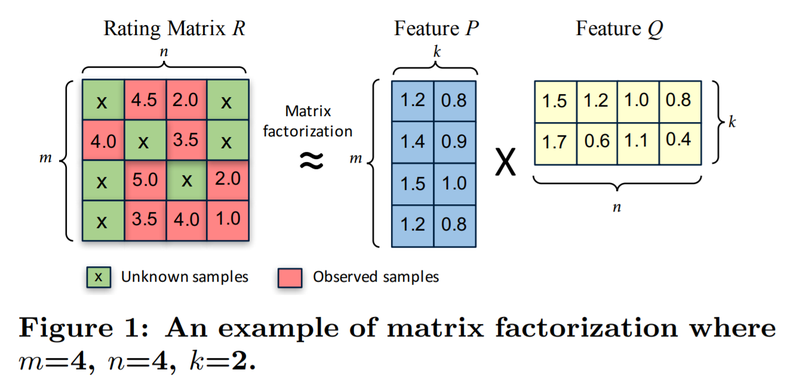

**MF의 아이디어**
>(m,n) 사이즈의 행렬 R을 (m,k) 사이즈의 행렬 P와 (k,n) 사이즈의 행렬 Q로 분해한다면 R이란 그저 P와 Q의 행렬곱으로 표현 가능하다!

#### 위 MF모델을 사용자에게 영화를 추천하는 모델에 대입

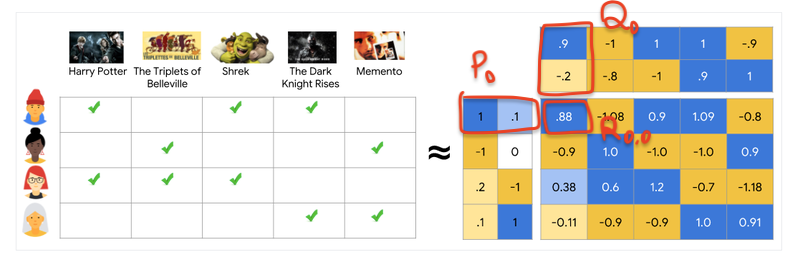

위 그림은 m = 4, n = 5, k = 2인 MF 모델.

$P_0=(1, 0.1)$은 빨간모자쓴 **사용자의 특성(Feature)벡터** <br>

$Q_0=(0.9, -0.2)$은 해리포터 **영화의 특성(Feature)벡터** <br>

이 두 벡터를 내적해서 얻어지는 0.88은 $R_{0,0}$로 정의되는 **사용자의 영화 선호도**

#### MF 모델의 목표는?
> - 모든 유저와 아이템에 대해 **k-dimension의 벡터를 잘 만드는 것**
> - 벡터를 잘 만드는 기준은 유저 i의 벡터($U_i$)와 아이템 j의 벡터($I_j$)를 내적했을 때 유저 i가 아이템 j에 대해 평가한 수치($M_{ij}$)와 비슷한지 <br>
> $U_i * I_j = M_{ij}$

이번 실습에선 [Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf) 논문에서 제안한 모델을 사용할 것.

논문의 모델이 근사하고자 하는 것이 아티스트를 선호하는지 안 하는지를 맞추는 것이기 때문에 내가 eminem 노래를 5번 들었어도 **나의 특징 벡터와 eminem의 특징 벡터를 곱했을 때 5가 아닌 1에 가까워져야한다.**